In [1]:
%matplotlib inline
import torch
from torchvision import transforms, models
from torch import optim, device
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
vgg = models.vgg19(pretrained=True).features

In [3]:
t = models.vgg19(pretrained=True)

In [4]:
for i in vgg.parameters():
    i.requires_grad_(False)

In [5]:
# torch.nn.parameter.Parameter.requires_grad()

In [6]:
device =torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [7]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [8]:
style = Image.open('./style.jpg')
content = Image.open('./content.jpg')

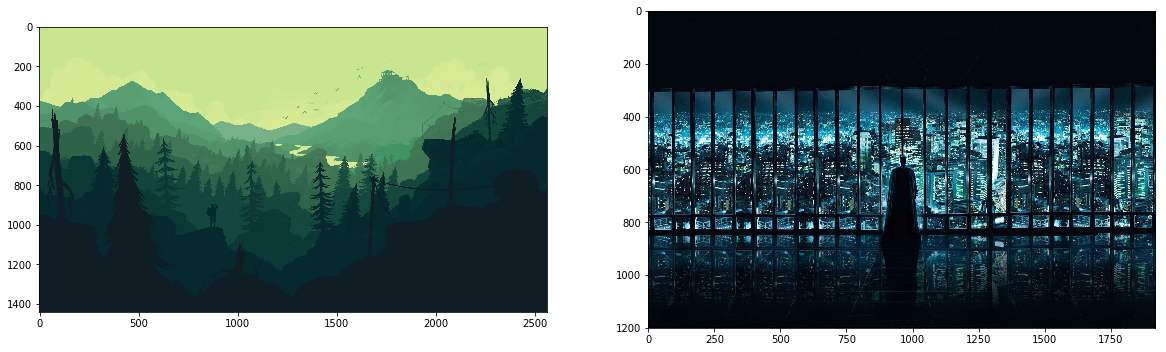

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(style)
ax2.imshow(content)

In [10]:
def convert_image(image, max_size=400):
    size=0
    if max(image.size)>max_size:
        size = max_size
    else:
        size = image.size
    im_tf = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    #why are we doing it this way reason is still unknown
    image = im_tf(image)[:3,:,:].unsqueeze(0)
    return image

In [11]:
style=convert_image(style).to(device)
content = convert_image(content).to(device)

In [12]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {
            '0':'conv1_1',
            '5':'conv2_1',
            '10':'conv3_1',
            '19':'conv4_1',
            '21':'conv4_2',
            '28':'conv5_1'
        }
    features = {}
    x = image
    
    for name,layer in model._modules.items():
#         print(layers.items())
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [13]:
def gram(tensor):
    
    c, d, h, w = tensor.shape
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor,tensor.t())
    
    return gram

In [14]:
style_features = get_features(style, vgg)
content_features = get_features(content, vgg)


style_gram = {layer:gram(style_features[layer])for layer in style_features}
#in the paper this was whit noise  image
target = content.clone().requires_grad_(True).to(device)

In [15]:
style_weights = {
    'conv1_1':1.,
    'conv2_1':0.8,
    'conv3_1':0.5,
    'conv4_1':0.3,
    'conv5_1':0.1
}
content_weight = 1 #alpha
style_weight = 1e6 #beta

In [16]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
show_every = 2000
optimizer = optim.Adam([target], lr=0.004)
steps = 2000

for i in range(1, steps+1):
    
    target_festures = get_features(target, vgg)
    content_loss = torch.mean((target_festures['conv4_2']-content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_festures[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram(target_feature)
        layer_style_loss = style_weights[layer]*torch.mean((target_gram-style_gram[layer])**2)
        style_loss+= layer_style_loss/d*h*w#still dunno why dividing
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%show_every==0:
        print(f'total_loss:{total_loss.item()}')
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
for layer in style_weights:
    print(layer)

In [ ]:
content_features